In [1]:
import numpy as np
import pandas as pd
import cPickle
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Reading tweets

In [2]:
bank_train = pd.read_csv('../data/bank_train.csv', sep='\t', encoding='utf-8')

In [3]:
bank_train.head()

,id,text,label
0,1,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,0
1,2,Мнение о кредитной карте втб 24 http://t.co/SB...,0
2,3,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,0
3,4,Современное состояние кредитного поведения в р...,0
4,5,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,1


In [4]:
texts, labels = bank_train.text.values, bank_train.label.values

### Reading vocabulary and embeddings

In [5]:
word2id, embeddings = cPickle.load(open('../data/w2v/vectors_l.pkl', 'rb'))
# word2id, embeddings = cPickle.load(open('../data/w2v/parkin_vectors.pkl', 'rb'))

In [6]:
vocabulary = word2id.keys()
eos_id = word2id[u'</s>']

### Lemmatizing and replacing words with ids

In [7]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(u'[а-яА-Я]+')
morph = pymorphy2.MorphAnalyzer()

def text2seq(text):
    tokens_norm = [morph.parse(w)[0].normal_form for w in tokenizer.tokenize(text)]
    return [word2id[w] for w in tokens_norm if w in vocabulary] + [eos_id]

sample = texts[49]

print sample
print u' '.join(tokenizer.tokenize(sample))
print u' '.join([morph.parse(w)[0].normal_form for w in tokenizer.tokenize(sample)])
print text2seq(sample)

http://t.co/14dY9LVVeV Взять кредит на технику в альфа банке
Взять кредит на технику в альфа банке
взять кредит на техника в альфа банка
[218, 992, 5, 1032, 2, 6915, 979, 0]


Dumping

Loading

In [8]:
X = cPickle.load(open('../data/X_bank_train_full.pkl', 'rb'))

Distribution of sequences' lengths 

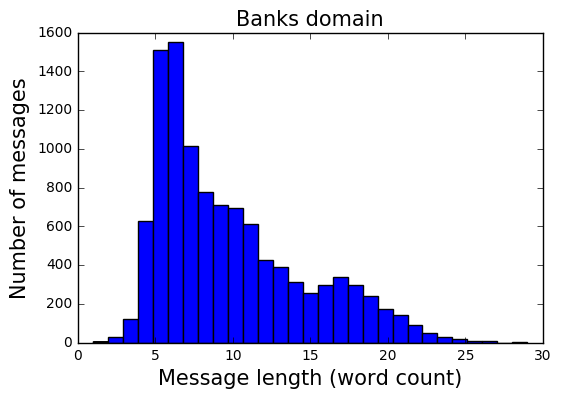

In [9]:
length_max = max(map(len, X))
plt.hist(map(len, X), bins=length_max)
plt.title("Banks domain", fontsize=15)
plt.xlabel("Message length (word count)", fontsize=15)
plt.ylabel("Number of messages", fontsize=15)
plt.show()

### Zero padding

In [10]:
X = [x + [eos_id]*(length_max - len(x)) for x in X]

### Examples

In [11]:
for x in X[:4]:
    print x

[218, 992, 10694, 6915, 1730, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[192, 26, 5239, 1196, 10418, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[67959, 2767, 2520, 1918, 2234, 5, 2306, 2, 29, 3832, 76, 10158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[544, 627, 5239, 1297, 2, 32, 5599, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### One-hot encode labels

In [12]:
X = np.array(X)
y = bank_train.label.values

In [13]:
def cls2probs(cls):
    if cls == -1:
        return [1., 0., 0.]
    elif cls == 0:
        return [0., 1., 0.]
    else:
        return [0., 0., 1.]

y = np.array([cls2probs(cls) for cls in y])

### Split into train and validation sets

In [14]:
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=VAL_SIZE, random_state=40)

In [15]:
print "Train class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_tr.transpose()]
print "Validation class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()]
print "Constant classifier's validation accuracy:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()][1] * 1. / y_val.shape[0]

Train class frequencies:	[2517, 6449, 686]
Validation class frequencies:	[290, 709, 74]
Constant classifier's validation accuracy:	0.660764212488


### Resampling

---

# Network learning

In [16]:
import tensorflow as tf
from tensorflow.contrib.rnn import GRUCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.layers import fully_connected

from utils import *

In [17]:
y_pred_major = np.zeros(y_val.shape)
y_pred_major[:,0] = 1.
print "Constant classifier's F-score on validation set:", f_macro(y_val, y_pred_major)

Constant classifier's F-score on validation set: 0.212765957447


---

### Bi-RNN with Attention mechanism

Attention mechanism formulas and notation
$$
\upsilon_{t}=\tanh{(W_{\omega}\left[\overrightarrow{h_{t}},\overleftarrow{h_{t}}\right]+b_{\omega})}\\
\alpha_{t}=\frac{\exp{(\upsilon_{t}^{T}u_{\omega})}}{\sum_{j=1}^{T}\exp{(\upsilon_{j}^{T}u_{\omega})}}\\
\upsilon=\sum_{t=1}^{T}\alpha_{t}h_{t}	
$$

In [18]:
EMBED_DIM = 300
SEQ_LENGTH = length_max
HIDDEN_SIZE = 300
ATTENTION_SIZE = 100
NUM_CLASSES = 3

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, SEQ_LENGTH])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)

batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)

# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(outputs, 2)
# outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs = tf.concat(outputs, 2)

# Attention mechanism
W_omega = tf.Variable(tf.random_normal([2 * HIDDEN_SIZE, ATTENTION_SIZE], stddev=0.1))
b_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))
u_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))

v = tf.tanh(tf.matmul(tf.reshape(outputs, [-1, 2 * HIDDEN_SIZE]), W_omega) + tf.reshape(b_omega, [1, -1]))
vu = tf.matmul(v, tf.reshape(u_omega, [-1, 1]))
exps = tf.reshape(tf.exp(vu), [-1, SEQ_LENGTH])
alphas = exps / tf.reshape(tf.reduce_sum(exps, 1), [-1, 1])

# Output of Bi-RNN reduced with attention vector
output = tf.reduce_sum(outputs * tf.reshape(alphas, [-1, SEQ_LENGTH, 1]), 1)

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [19]:
# Adam parameters
LEARNING_RATE = 1e-4
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=target_ph),
                               name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
                                   epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.AdadeltaOptimizer(learning_rate=LEARNING_RATE, rho=0.7).minimize(loss)
# optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.1).minimize(loss)
# optimizer = tf.train.MomentumOptimizer(learning_rate=1e-1, momentum=0.1).minimize(loss)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.9, momentum=0.1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 99
	 Train loss: 0.043	 ce: 0.043	 acc: 0.992	 f_macro: 0.976
	 Valid loss: 0.558	 ce: 0.558	 acc: 0.894	 f_macro: 0.739


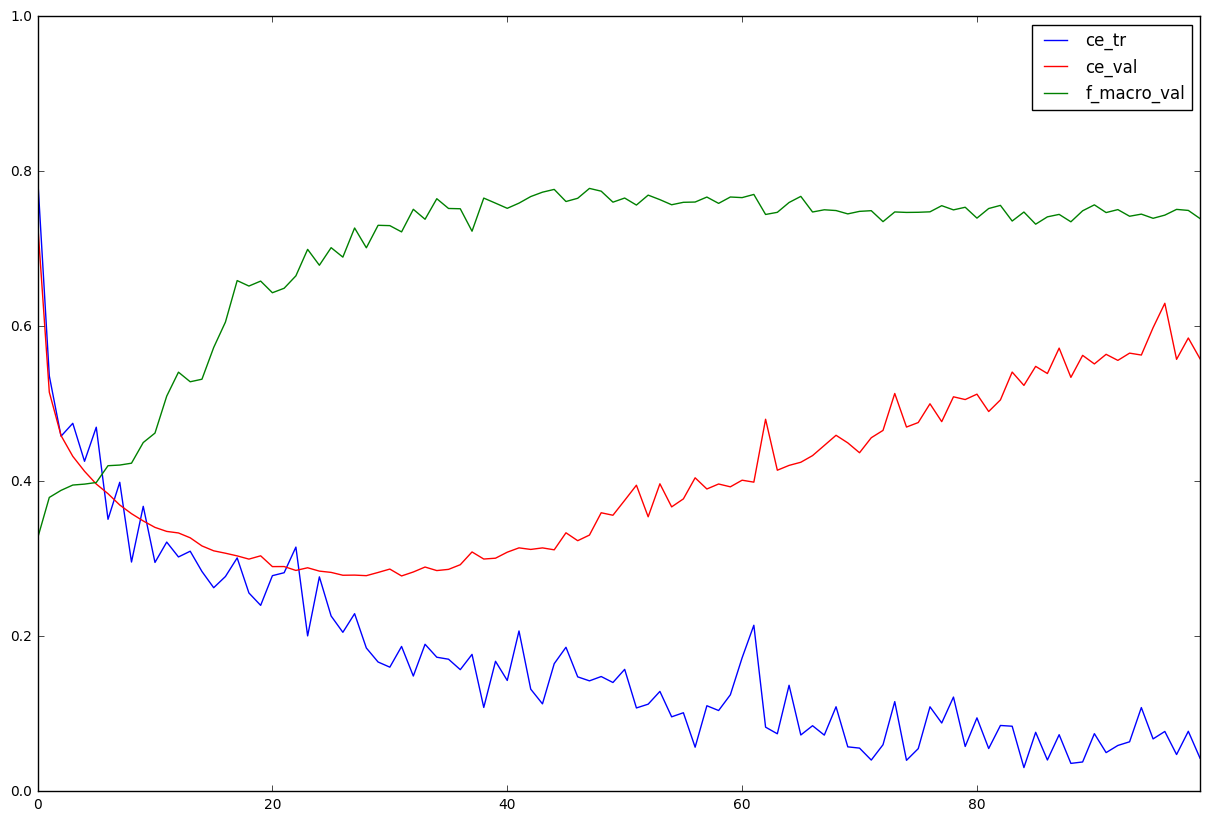

In [20]:
DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 100

results = []

train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

loss_tr_l = []
loss_val_l = []
ce_tr_l = []  # Cross-entropy
ce_val_l = []
acc_tr_l = []  # Accuracy
acc_val_l = []
f_macro_tr_l = []
f_macro_val_l = []
f_fair_tr_l = []
f_fair_val_l = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
    print "Start learning..."
    for epoch in range(EPOCHS):
        for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
            x_batch, y_batch = train_batch_generator.next()
            seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
            sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                           seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

        y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                              feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                         seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
        seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
        y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})


        y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
        y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
        f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
        f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)

        loss_tr_l.append(loss_tr)
        loss_val_l.append(loss_val)
        ce_tr_l.append(ce_tr)
        ce_val_l.append(ce_val)
        acc_tr_l.append(acc_tr)
        acc_val_l.append(acc_val)
        f_macro_tr_l.append(f_macro_tr)
        f_macro_val_l.append(f_macro_val)

        clear_output(wait=True)
        print "epoch: {}".format(epoch)
        print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_tr, ce_tr, acc_tr, f_macro_tr)
        print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_val, ce_val, acc_val, f_macro_val)

        plt.figure(figsize=(15,10))
        plt.plot(ce_tr_l, color='blue', label='ce_tr')
        plt.plot(ce_val_l, color='red', label='ce_val')        
        plt.plot(f_macro_val_l, color='green', label='f_macro_val')
        plt.xlim(0, EPOCHS - 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

    saver = tf.train.Saver() 
    saver.save(sess, 'model')

In [21]:
print acc_val, f_macro_val

0.893756 0.739179802298


---

---

---

# Testing

In [22]:
bank_test = pd.read_csv('../data/bank_test.csv', sep='\t', encoding='utf-8')
texts_test, labels_test = bank_test.text.values, bank_test.label.values

In [23]:
X_test = cPickle.load(open('../data/X_bank_test.pkl', 'rb'))

In [24]:
X_test = [x + [eos_id]*(length_max - len(x)) for x in X_test]
X_test = np.array(X_test)
y_test = np.array([cls2probs(cls) for cls in labels_test])

In [25]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in X_test])
    y_pred_test, ce_test, loss_test, acc_test = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                     feed_dict={batch_ph: X_test, target_ph: y_test,
                                                                seq_len_ph: seq_len_test, keep_prob_ph: 1.0})
    seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
    y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})

In [26]:
y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)
print f_macro_val, f_micro_val

0.739179802298 0.818304172275


In [27]:
y_pred_test = np.array([cls2probs(cls) for cls in np.argmax(y_pred_test, 1) - 1])
f_macro_test, f_micro_test = f_macro(y_test, y_pred_test), f_micro(y_test, y_pred_test)
print f_macro_test, f_micro_test

0.494204049857 0.52677508925


In [49]:
id2word = {}
for word, word_id in word2id.iteritems():
    id2word[word_id] = word

In [54]:
sentence=texts_test[160]
print sentence

@RSHBmedia почему такой неудобный и не информативный интернет-банк? Учитесь у @sberbank и его Сбербанк-онлайн.


In [56]:
print " ".join(tokenizer.tokenize(sentence))

почему такой неудобный и не информативный интернет банк Учитесь у и его Сбербанк онлайн


In [57]:
tokens = ["почему", "такой", "неудобный", "и", "не", "информативный", "интернет-", "банк?",
          "Учитесь", "у @sberbank", "и", "его", "Сбербанк-", "онлайн."]

In [53]:
print X_test[160]

[  103    30  6611     1     3 18272   413  1730   686    18     1    15
  5599  5852     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]


In [51]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    x_batch_test, y_batch_test = X_test[160:161], y_test[160:161]
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in x_batch_test])
    y_pred_test, alphas_test = sess.run([y_hat, alphas],
                                                 feed_dict={batch_ph: x_batch_test, target_ph: y_batch_test,
                                                            seq_len_ph: seq_len_test, keep_prob_ph: 1.0})

In [52]:
y_pred_test

array([[ 3.81976366, -7.70932531,  3.54561615]], dtype=float32)

In [59]:
for word, coef in zip(tokens, alphas_test[0,:len(tokens)] * 1000 / 1.81):
    print "\colorbox{yellow!%d}{%s}" % (int(coef), word)

\colorbox{yellow!87}{почему}
\colorbox{yellow!100}{такой}
\colorbox{yellow!69}{неудобный}
\colorbox{yellow!71}{и}
\colorbox{yellow!69}{не}
\colorbox{yellow!68}{информативный}
\colorbox{yellow!3}{интернет-}
\colorbox{yellow!3}{банк?}
\colorbox{yellow!8}{Учитесь}
\colorbox{yellow!16}{у @sberbank}
\colorbox{yellow!17}{и}
\colorbox{yellow!12}{его}
\colorbox{yellow!19}{Сбербанк-}
\colorbox{yellow!1}{онлайн.}


---

In [101]:
idx = 821
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    x_batch_test, y_batch_test = X_test[idx:idx + 1], y_test[idx:idx + 1]
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in x_batch_test])
    y_pred_test, alphas_test = sess.run([y_hat, alphas],
                                                 feed_dict={batch_ph: x_batch_test, target_ph: y_batch_test,
                                                            seq_len_ph: seq_len_test, keep_prob_ph: 1.0})

In [102]:
print texts_test[idx]
tokens = texts_test[idx].split()
tokens = tokenizer.tokenize(texts_test[idx])
coefs = alphas_test[0,:len(tokens)] / max(alphas_test[0,:len(tokens)])
for word, coef in zip(tokens,  coefs * 100):
    print "\colorbox{yellow!%d}{%s}" % (int(coef), word)

@sberbank Почему-то не приходят смс-сообщения для подтверждения входа
\colorbox{yellow!61}{Почему}
\colorbox{yellow!77}{то}
\colorbox{yellow!100}{не}
\colorbox{yellow!57}{приходят}
\colorbox{yellow!15}{смс}
\colorbox{yellow!22}{сообщения}
\colorbox{yellow!5}{для}
\colorbox{yellow!7}{подтверждения}
\colorbox{yellow!0}{входа}


In [100]:
for i, (c, l) in enumerate(zip(texts_test, labels_test)[800:1200]):
    if l == -1:
        print i, l, c

1 -1 Сбербанк: Банк друзей
Многоуважаемый банк!
Нельзя ли как-нибудь оградить меня от иронических реплик друзей,... http://t.co/YtIPk2GMy3
3 -1 RT @donaldiboforiw: #Не могу снять деньги с кредитки сбербанка
8 -1 RT @kennethimujebad: http://t.co/MNY6rwzejR #Сбербанк онлайн не видит мою
9 -1 Крупнейшие российские банки сокращают персонал в своих западных отделениях. Сбербанк уволил в своем офисе в Лондоне семь человек, сообщает
11 -1 Правильно. 
Сбербанку и работодателю я бы тоже не доверил свой паспорт. 
Куда потом пойдет скан паспорта никаму не известно.&amp;raquo;
15 -1 nesty
Привет,ты не знаешь со скольки работают сбербанки?
Ёрик @home
привет, они вообще не работают
Ёрик @home
они сидят и пиздят весь
21 -1 @sberbank Почему-то не приходят смс-сообщения для подтверждения входа
32 -1 @Alexey_Pushkov Греф  отказывается в Крым  приходить со своим  сбербанком и Костин глава ВТБ,также  они   дочки  своих банком  на Украине
34 -1 потом ждешь полчаса, когда придут деньги и с третьей попытки (